# Entre vie, greffe et décès : Analyse prédictive appliquée à une cohorte hépatique

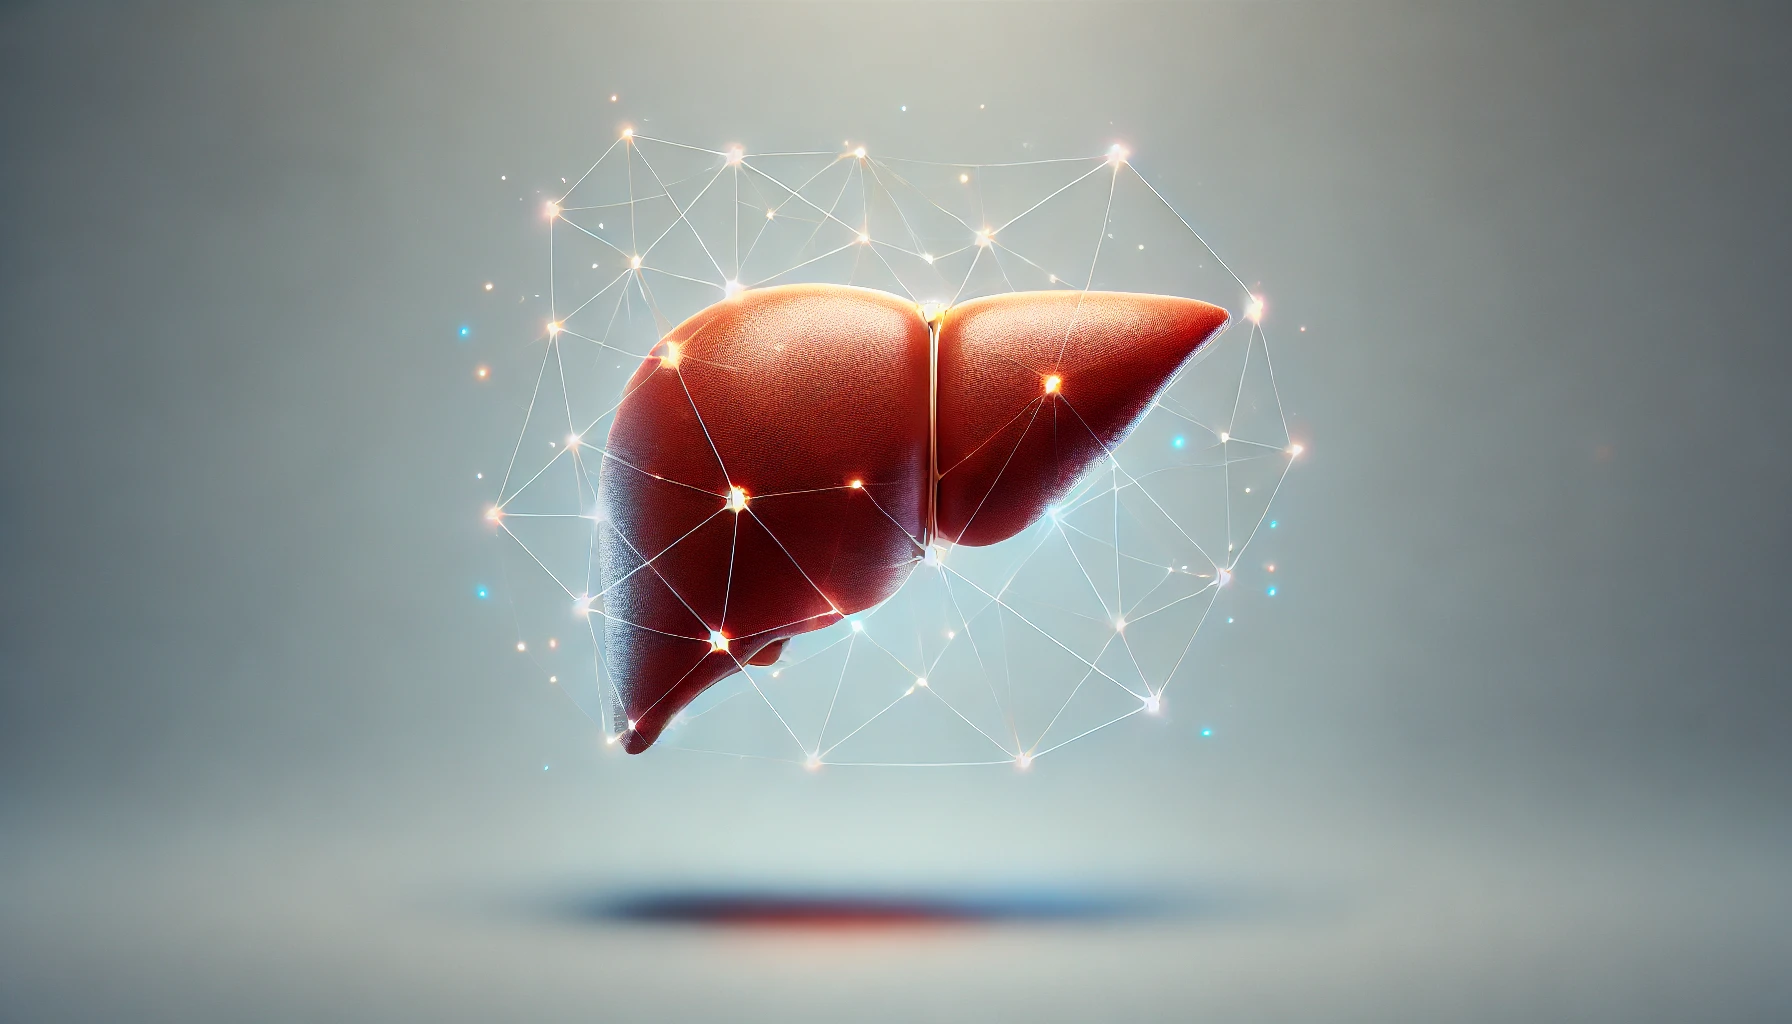

## **Introduction**

La prédiction du pronostic vital chez les patients atteints de maladies hépatiques représente un enjeu majeur en santé publique, tant pour optimiser la prise en charge médicale que pour anticiper les évolutions cliniques. Dans ce contexte, ce projet a pour objectif de développer un modèle de classification permettant d’estimer, pour chaque patient, la probabilité d’appartenir à l’une des trois catégories suivantes : Status_C (patient vivant), Status_CL (patient vivant ayant bénéficié d’une transplantation hépatique) et Status_D (patient décédé).

Les performances des modèles sont évaluées à l’aide du log loss, une métrique qui mesure la qualité des probabilités prédites et pénalise fortement les erreurs de calibration. L’objectif final est donc de minimiser cette valeur afin d’obtenir des prédictions fiables et précises des probabilités associées à chaque issue possible.

Pour mener à bien ce travail, nous suivrons une démarche structurée. Nous commencerons par une analyse exploratoire approfondie des données afin de mieux comprendre les caractéristiques de la cohorte et d’identifier les éventuelles anomalies. Nous procéderons ensuite à la gestion des valeurs manquantes et des valeurs aberrantes, étapes essentielles pour garantir la qualité et la robustesse des données utilisées.

Dans un premier temps, nous mettrons en œuvre une régression logistique multinomiale, choisie pour sa simplicité et sa capacité à modéliser des sorties multiclasses probabilistes. Enfin, afin d’améliorer la performance du modèle initial, nous expérimenterons des approches plus complexes, notamment l’algorithme XGBoost, reconnu pour son efficacité sur des problématiques de classification multiclasses et sa capacité à gérer des données hétérogènes et bruitées.

À travers cette approche progressive, nous chercherons à identifier le modèle le plus performant et le mieux calibré pour prédire le statut vital des patients, en veillant à assurer la robustesse des résultats aussi bien sur nos jeux de données internes que sur le dataset d’évaluation externe fourni par Kaggle.

### Chargement et traitement des données

#### Importation des librairies nécessaires

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kstest
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Chargement de la table d'apprentissage

In [3]:
train_data = pd.read_csv("/kaggle/input/classification-multi-classes/train.csv")
train_data.shape

(15000, 20)

#### Chargement de la table test

In [4]:
test_data = pd.read_csv("/kaggle/input/classification-multi-classes/test.csv")
test_data.shape

(10000, 19)

### **Analyse Exploratoire des données - Table d'apprentissage**

In [4]:
train_data.head(4)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1055.0,NaN,19724.0,F,NaN,NaN,NaN,N,1.3,NaN,3.64,NaN,NaN,NaN,NaN,209.0,10.5,3.0,C
1,1,3282.0,Placebo,17884.0,F,N,Y,Y,N,0.7,309.0,3.60,96.0,1142.0,71.3,106.0,240.0,12.4,4.0,C
2,2,1653.0,NaN,20600.0,F,NaN,NaN,NaN,N,2.2,NaN,3.64,NaN,NaN,NaN,NaN,139.0,9.5,2.0,C
3,3,999.0,D-penicillamine,22514.0,F,N,Y,N,N,1.0,498.0,3.35,89.0,1601.0,164.3,85.0,394.0,9.7,3.0,C


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8564 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8563 non-null   object 
 6   Hepatomegaly   8564 non-null   object 
 7   Spiders        8555 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6669 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8452 non-null   float64
 13  Alk_Phos       8558 non-null   float64
 14  SGOT           8555 non-null   float64
 15  Tryglicerides  6630 non-null   float64
 16  Platelets      14414 non-null  float64
 17  Prothrombin    14974 non-null  float64
 18  Stage 

**Observations**
* La table d'apprentissage contient 15,000 observations et 20 variables dont une variable "id" pour identifier les patients.
* Nous avons 7 variables de type catégorielle et 13 de type numérique.
* Plus de la moitié des variables ont des valeurs manquantes.

Voyons quel pourcentage est manquant pour chacune de ces variables.

In [6]:
(train_data.isnull().sum() / train_data.shape[0]) * 100

id                0.000000
N_Days            0.000000
Drug             42.906667
Age               0.000000
Sex               0.000000
Ascites          42.913333
Hepatomegaly     42.906667
Spiders          42.966667
Edema             0.000000
Bilirubin         0.000000
Cholesterol      55.540000
Albumin           0.000000
Copper           43.653333
Alk_Phos         42.946667
SGOT             42.966667
Tryglicerides    55.800000
Platelets         3.906667
Prothrombin       0.173333
Stage             0.000000
Status            0.000000
dtype: float64

La majeure partie des variables a un pourcentage de valeurs manquantes variant entre 42 et 55%, ce qui représente un pourcentage assez élevé.

Effectuons une analyse de corrélation (pour les variables numériques) avec les autres variables de la base pour voir si on peut garder ou enlever ces variables. Si elles sont (fortement) corrélées avec les autres variables de la base, on peut envisager d'imputer les valeurs manquantes. Autrement, on peut analyser la nature de ce manque: s'il est aléatoire ou non.

Mais imputer plus de 50% de valeurs manquantes n'est pas sans conséquence. Il peut y avoir une introduction de biais dans les données et un risque de perte d'information et de performance.

#### Traitement des valeurs manquantes - Variables numériques

Dans cette partie, nous allons traiter les valeurs manquantes des variables numériques. Nous allons commencer par une analyse de la corrélation entre les variables, puis nous allons tester si les variables ici présentes sont informatives ou non. Cela pourra nous aider à enlever des variables avec trop de valeurs manquantes et non informatives et de travailler uniquement avec celles qui comptent vraiment, c'est-à-dire que leur valeur suivant la classe de la variable cible n'est pas aléatoire.

In [5]:
# Liste des variables numériques

train_df1 = train_data.drop("id", axis = 1)
num_cols = train_df1.select_dtypes(["int64", "float64"]).columns.tolist()
num_cols

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

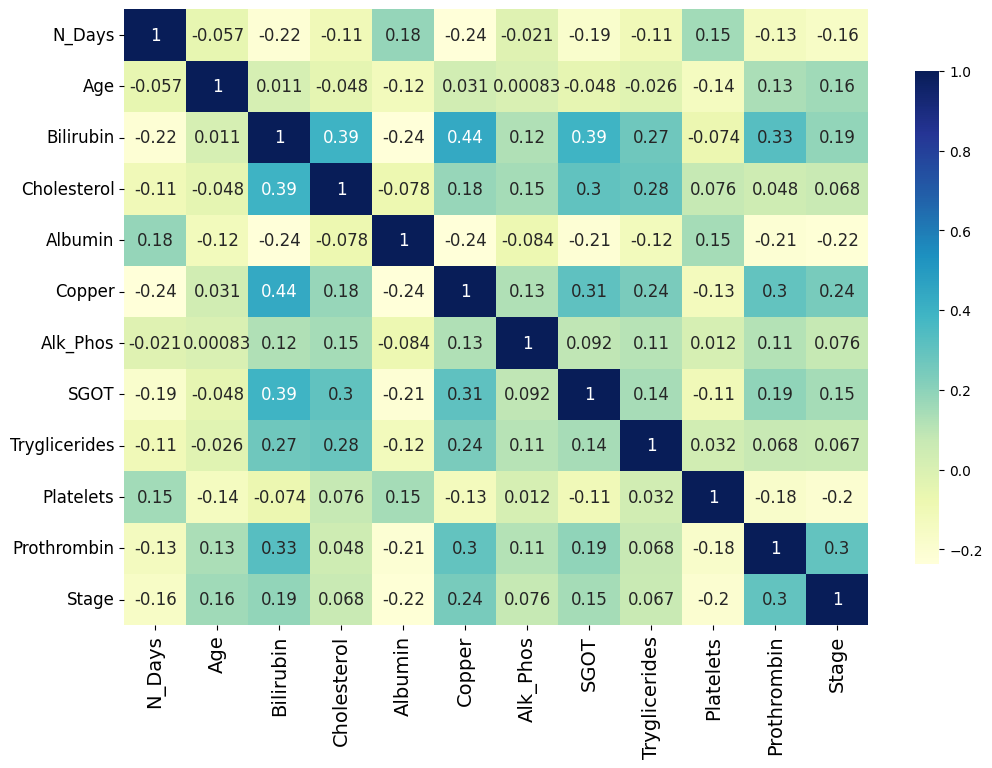

In [5]:
# Création d'un heatmap pour représenter le niveau des corrélations
plt.figure(figsize = (12, 8))
sns.heatmap(
    train_df1[num_cols].corr(), 
    annot=True, 
    cmap="YlGnBu", 
    annot_kws={"size": 12}, 
    cbar_kws={"shrink": 0.8}, 
)

# Ajuster les tailles des labels des axes
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)

plt.show();

**Observations**

Ce heatmap présente les corrélations entre les variables du dataset afin d’évaluer leur niveau de redondance et d’identifier d’éventuelles variables à éliminer. De manière générale, les corrélations sont faibles, ce qui indique que la majorité des variables sont relativement indépendantes les unes des autres. Toutefois, quelques relations modérées se démarquent, notamment entre Bilirubin et Copper (0.44) ainsi que Bilirubin et SGOT (0.39), suggérant qu’il pourrait exister une certaine interdépendance entre ces marqueurs biologiques. Une relation similaire, bien que plus faible, est observée entre Cholesterol et SGOT (0.3) ainsi que Prothrombin et Stage (0.3), ce qui peut refléter un lien potentiel avec la progression de la maladie.

En revanche, certaines variables montrent des corrélations très faibles avec presque toutes les autres, notamment Age, Alk_Phos et Platelets, ce qui peut indiquer qu’elles n’apportent que peu d’information sur la structure des données. Cela ne signifie pas nécessairement qu’elles doivent être supprimées immédiatement, car une faible corrélation n’exclut pas leur importance dans un modèle prédictif. Nous allons analyser si ces variables sont informatives par rapport à notre variable cible "Status".

Vérifions si ces variables ont une relation statistiquement significative avec la variable cible "Status". Selon le résultat d'un test de normalité de ces deux variables, nous saurons si on doit réaliser un test de kruskal-wallis qui compare les médianes, ou implémenter une anova qui compare les moyennes des groupes.

La règle est la suivante:
* si normale, alors ANOVA
* sinon, kruskal-wallis (car notre variable cible a plus de 2 catégories)


Commençons par réaliser un test de normalité pour nos variables. Notre échantillon étant assez grand (> 5000 (2000, selon certaines littératures)), on va utilisr le test de Kolmogorov-Smirnov.

In [6]:
na_num_var = train_df1.select_dtypes(['number']).isnull().sum()[train_df1.select_dtypes('number').isnull().sum() > 0].index.to_list()
na_num_var

['Cholesterol',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin']

In [7]:
# ks = kolmogorov-smirnov
ks_results = []

for var in na_num_var:
    stat, p = kstest(train_df1[var].dropna(), 'norm')
    ks_results.append([var, stat, p])

ks_df = pd.DataFrame(ks_results, columns=['Variables', 'KS_Statistic', 'P-value'])

ks_df["KS_Statistic"] = ks_df["KS_Statistic"].apply(lambda x: f"{x:.5f}")
ks_df["P-value"] = ks_df["P-value"].apply(lambda x: f"{x:.5f}")

# Affichage
ks_df

,Variables,KS_Statistic,P-value
0,Cholesterol,1.00000,0.00000
1,Copper,0.99997,0.00000
2,Alk_Phos,1.00000,0.00000
3,SGOT,1.00000,0.00000
4,Tryglicerides,1.00000,0.00000
5,Platelets,0.99979,0.00000
6,Prothrombin,1.00000,0.00000


Ce tableau présente les résultats du test de Kolmogorov-Smirnov appliqué à plusieurs variables pour vérifier si elles suivent une distribution normale. Le test compare la distribution empirique des données à une distribution théorique (ici, la loi normale), et renvoie deux indicateurs principaux : la statistique KS et la p-value.

La statistique KS est très proche de 1 pour toutes les variables, indiquant une forte différence entre la distribution des données et une distribution normale. De plus, la p-value est égale à 0.00000 dans tous les cas, ce qui signifie qu’elle est inférieure au seuil de significativité habituel (0.05). Par conséquent, on rejette l’hypothèse de normalité pour toutes ces variables. En d’autres termes, ces variables ne suivent pas une distribution normale, et utiliser des méthodes qui supposent la normalité (comme certaines statistiques paramétriques) pourrait ne pas être approprié sans transformation préalable.

Avec ces résultats, utilisons un test de kruskal-wallis pour voir si nos variables sont informatives.

In [8]:
# kw = kruskal-wallis
kw_results = []

# Boucle sur chaque variable
for var in na_num_var:
    groups = [train_df1[var][train_df1["Status"] == val].dropna() for val in train_df1["Status"].unique()]
    stat, p = kruskal(*groups) 
    kw_results.append([var, stat, p])

# Création du DataFrame avec formatage des résultats
kw_df = pd.DataFrame(kw_results, columns=['Variable', 'KW_Statistic', 'P-value'])
kw_df["KW_Statistic"] = kw_df["KW_Statistic"].apply(lambda x: f"{x:.5f}")
kw_df["P-value"] = kw_df["P-value"].apply(lambda x: f"{x:.5f}")

# Affichage
kw_df

,Variable,KW_Statistic,P-value
0,Cholesterol,188.20640,0.00000
1,Copper,1734.76652,0.00000
2,Alk_Phos,623.74589,0.00000
3,SGOT,1305.69298,0.00000
4,Tryglicerides,214.36928,0.00000
5,Platelets,892.81423,0.00000
6,Prothrombin,3040.64248,0.00000


Ce tableau présente les résultats du test de Kruskal-Wallis, une méthode non paramétrique utilisée pour comparer les distributions d’une variable entre plusieurs groupes (dans ce cas, les différentes classes de la variable "Status"). Ce test est une alternative à l’ANOVA lorsque l’hypothèse de normalité n’est pas respectée, ce qui a été confirmé par le test de Kolmogorov-Smirnov précédent.

**Interprétation des résultats** :

* La statistique KW (Kruskal-Wallis) est élevée pour toutes les variables, indiquant une forte variation entre les groupes.
* La p-value est de 0.00000 dans tous les cas, ce qui signifie qu’elle est inférieure au seuil de significativité de 0.05.

**Conclusion** : on rejette l’hypothèse nulle qui stipule que les groupes ont des distributions identiques.

Cela signifie que ces variables sont significativement différentes entre les groupes, et donc qu’elles sont potentiellement informatives pour distinguer les catégories de la variable cible (Status).

**Implications** : Puisque ces variables montrent des différences significatives entre les groupes, elles sont pertinentes pour une modélisation prédictive. Il serait donc inapproprié de les éliminer. Ces résultats confirment que ces variables peuvent contribuer à la classification et devraient être conservées dans l’analyse.

#### **Imputation des valeurs manquantes par la médiane par classe de la variable dépendante - Taux de valeurs manquantes > 30%**

In [9]:
na_num_var.remove('Platelets')
na_num_var.remove('Prothrombin')

for var in na_num_var:
    for val in train_df1['Status'].unique():
        median_value = train_df1.loc[train_df1['Status'] == val, var].median()
        train_df1.loc[(train_df1['Status'] == val) & (train_df1[var].isna()), var] = median_value
        
pd.DataFrame(train_df1[na_num_var].isnull().sum(), columns=['Missing_values'])

,Missing_values
Cholesterol,0
Copper,0
Alk_Phos,0
SGOT,0
Tryglicerides,0


Ce tableau nous montre que toutes les valeurs manquantes des variables numériques avec un taux > 30% de valeurs manquantes ont été traitées. Les valeurs manquantes ont été remplacées par la médiane selon le statut.

#### **Imputation par la médiane globale des valeurs manquantes - Taux de valeurs manquantes < 30%**

In [10]:
for var in ['Platelets', 'Prothrombin']:
    train_df1[var] = train_df1[var].fillna(train_df1[var].median())

pd.DataFrame(train_df1[['Platelets', 'Prothrombin']].isnull().sum(), columns=['Missing_values'])

,Missing_values
Platelets,0
Prothrombin,0


De même, ce tableau nous montre que les valeurs manquantes des variables avec moins de 10% de valeurs manquantes ont été traitées et remplacées par la médiane globale de la variable.

#### **Traitement des valeurs manquantes - Variables catégorielles**

Dans cette partie, nous allons traiter les valeurs manquantes des variables catégorielles. Le traitement qui sera appliqué ici sera l'imputation par le mode.

In [11]:
na_cat = train_df1.select_dtypes('object').isnull().sum()[train_df1.select_dtypes('object').isnull().sum() > 0].index.to_list()

for var in na_cat:
    print(f"{var}: ", train_df1[var].unique())

Drug:  [nan 'Placebo' 'D-penicillamine']
Ascites:  [nan 'N' 'Y' 'S' 'D-penicillamine']
Hepatomegaly:  [nan 'Y' 'N' '119.35']
Spiders:  [nan 'Y' 'N']


**Observations**

* Drug - Deux catégories sont présentes : Placebo et D-penicillamine. Nous constatons aussi des valeurs manquantes (nan).
* Ascites - Catégories observées : N (Non), Y (Oui), et quelques valeurs inhabituelles comme S et D-penicillamine, qui semblent être des erreurs ou des valeurs mal encodées.
* Hepatomegaly - Catégories observées : Y (Oui), N (Non) et une valeur 119.35, qui semble être une anomalie ou une valeur mal classée.
* Spiders - Catégories observées : Y (Oui), N (Non), et des valeurs manquantes.

In [12]:
for var in na_cat:
    print(train_df1[var].value_counts(1))
    print("*"*40)

Drug
D-penicillamine    0.533396
Placebo            0.466604
Name: proportion, dtype: float64
****************************************
Ascites
N                  0.955039
Y                  0.044727
S                  0.000117
D-penicillamine    0.000117
Name: proportion, dtype: float64
****************************************
Hepatomegaly
N         0.532929
Y         0.466955
119.35    0.000117
Name: proportion, dtype: float64
****************************************
Spiders
N    0.791701
Y    0.208299
Name: proportion, dtype: float64
****************************************


**Brève interprétation des données**

Drug :
* D-penicillamine a été administré dans 53,34% des cas.
* Placebo a été administré dans 46,66% des cas.
  
→ La répartition du traitement est assez équilibrée entre les deux groupes.

Ascites :
* N (Absence d’ascite) représente 95,5% des cas.
* Y (Présence d’ascite) est beaucoup plus rare, 4,47%.
* S et D-penicillamine apparaissent avec une fréquence très faible (0,012%), probablement des erreurs de saisie.
  
→ La majorité des patients ne présentent pas d’ascite.

Hepatomegaly :
* N (Absence d’hépatomégalie) représente 53,29% des cas.
* Y (Présence d’hépatomégalie) est légèrement moins fréquente, 46,70%.
* 119.35 semble être une erreur de saisie, avec une fréquence marginale (0,012%).
  
→ La répartition est relativement équilibrée.

Spiders :
* N (Absence d’angiomes stellaires) est observé dans 79,17% des cas.
* Y (Présence d’angiomes stellaires) concerne 20,83% des patients.
  
→ La majorité des patients ne présentent pas cette caractéristique, mais elle reste significative.


**Conclusion**

Comme nous l'avons constaté, il y a quelques anomalies (valeurs inhabituelles dans Ascites et Hepatomegaly) qui nécessitent un nettoyage avant analyse approfondie. Aussi, les valeurs manquantes ne sont pas représentées dans ces tableaux. Nous allons donc aussi les traiter.

In [13]:
train_df1['Ascites'].replace(['S', 'D-penicillamine'], [np.nan, np.nan], inplace = True)
train_df1['Hepatomegaly'].replace("119.35", np.nan, inplace = True)

Nous remplaçons les valeurs inhabituelles ou anomalies par des valeurs manquantes.

In [14]:
for var in na_cat:
    print(train_df1[var].value_counts(1))
    print("*"*40)

Drug
D-penicillamine    0.533396
Placebo            0.466604
Name: proportion, dtype: float64
****************************************
Ascites
N    0.955262
Y    0.044738
Name: proportion, dtype: float64
****************************************
Hepatomegaly
N    0.532991
Y    0.467009
Name: proportion, dtype: float64
****************************************
Spiders
N    0.791701
Y    0.208299
Name: proportion, dtype: float64
****************************************


Les valeurs inhabituelles ont été remplacées par des valeurs manquantes.

In [15]:
# Remplacement de modalité
train_df1.loc[(train_df1['Drug'] == 'D-penicillamine'), "Drug"] = "D_penicillamine"

# Variables catégorielles avec des valeurs manquantes
train_df1[na_cat].isnull().sum()

Drug            6436
Ascites         6439
Hepatomegaly    6437
Spiders         6445
dtype: int64

Pour poursuivre le traitement des valeurs manquantes, nous effectuons un test d’indépendance du chi-deux afin de déterminer si les variables sont informatives. Ce test nous aidera à identifier la méthode la plus appropriée pour imputer les valeurs manquantes.

In [16]:
chi2_results = []

for var in na_cat:
    contingency_table = pd.crosstab(train_df1[var], train_df1['Status'])
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append([var, chi2_stat, p])


# Création du DataFrame avec formatage des résultats
chi2_df = pd.DataFrame(chi2_results, columns=['Variable', 'Chi2_Statistic', 'P-value'])
chi2_df["Chi2_Statistic"] = chi2_df["Chi2_Statistic"].apply(lambda x: f"{x:.5f}")
chi2_df["P-value"] = chi2_df["P-value"].apply(lambda x: f"{x:.5f}")

# Affichage
chi2_df

,Variable,Chi2_Statistic,P-value
0,Drug,10.39861,0.00552
1,Ascites,861.24891,0.00000
2,Hepatomegaly,1721.46292,0.00000
3,Spiders,1261.80055,0.00000


Nous obtenons une p-value < 0.05 pour toutes les variables, elles sont donc informatives. Dans ce contexte, nous allons remplacer les valeurs manquantes de ces variables par le mode de chaque classe de la variable dépendante 'Status' pour minimiser le risque d'introduction de biais.

In [17]:
# Imputation des valeurs manquantes par le mode par classe
for var in na_cat:
    for val in train_df1['Status'].unique():
        mode_value = train_df1[train_df1['Status'] == val][var].mode()
        train_df1.loc[train_df1['Status'] == val, var] = train_df1.loc[train_df1['Status'] == val, var].fillna(mode_value.iloc[0])

train_df1[na_cat].isnull().sum()

Drug            0
Ascites         0
Hepatomegaly    0
Spiders         0
dtype: int64

Ce tableau nous montre que toutes les valeurs manquantes des variables catégorielles ont été traitées.

Les valeurs manquantes étant traitées, nous pouvons passer à une autre phase de l'analyse de la base d'apprentissage.

### **Analyse univariée - Table d'apprentissage**

#### Analyse descriptive des variables continues

In [26]:
train_df1.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,15000.0,1966.998733,1355.897299,3.0,1092.00,1785.00,2635.00,40795.00
Age,15000.0,19248.502373,3697.546749,133.3,16374.00,19544.00,22369.00,35472.00
Bilirubin,15000.0,1.861462,2.752375,0.3,0.60,0.90,1.80,28.00
Cholesterol,15000.0,302.689433,122.405543,120.0,273.00,273.00,300.00,1790.00
Albumin,15000.0,3.525314,0.369981,1.8,3.29,3.58,3.77,4.64
Copper,15000.0,68.032400,58.670716,4.0,41.00,41.00,94.00,588.00
Alk_Phos,15000.0,1431.814533,1439.957129,16.0,955.00,955.00,1441.00,19270.00
SGOT,15000.0,103.522984,45.141475,8.0,83.70,83.70,130.20,2148.00
Tryglicerides,15000.0,103.265250,33.772089,33.0,95.00,95.00,102.00,598.00
Platelets,15000.0,253.711780,92.220580,0.4,190.00,251.00,311.00,724.00



Le tableau ci-dessus présente les principales statistiques descriptives des variables continues de l’étude. Plusieurs points importants se dégagent de cette analyse :

1. **Forte variabilité et présence de valeurs extrêmes**

Certaines variables affichent des écarts-types élevés et des valeurs maximales largement supérieures aux valeurs du troisième quartile (75%), ce qui traduit une grande dispersion et la présence probable de valeurs aberrantes. Cela concerne notamment :
	•	N_Days, avec une moyenne de 1966,99 jours et un maximum atteignant 40 795 jours.
	•	Bilirubin, Cholesterol, Copper, Alk_Phos, SGOT et Tryglicerides, qui présentent des maximums très élevés par rapport à leur médiane.

2. **Distributions asymétriques**

Plusieurs variables montrent un décalage entre la moyenne et la médiane, ce qui indique une asymétrie des distributions. Par exemple :
	•	Bilirubin présente une moyenne de 1,86 alors que la médiane est de 0,90, soulignant une concentration des valeurs faibles et quelques observations très élevées.
	•	Copper et Alk_Phos présentent également ce type de comportement.

3. **Variables plus stables**

Certaines variables présentent des distributions plus resserrées et peu dispersées :
	•	Albumin (moyenne : 3,52 ; écart-type : 0,37) et Prothrombin (moyenne : 10,62 ; écart-type : 0,74) affichent des valeurs homogènes autour de leur moyenne, ce qui reflète une variabilité plus faible.

4. **Comportement discret de la variable Stage**

La variable Stage, qui représente vraisemblablement le stade d’évolution de la maladie, prend des valeurs comprises entre 1 et 4, avec une médiane à 3. Cela suggère une prédominance des cas aux stades intermédiaires ou avancés dans l’échantillon.

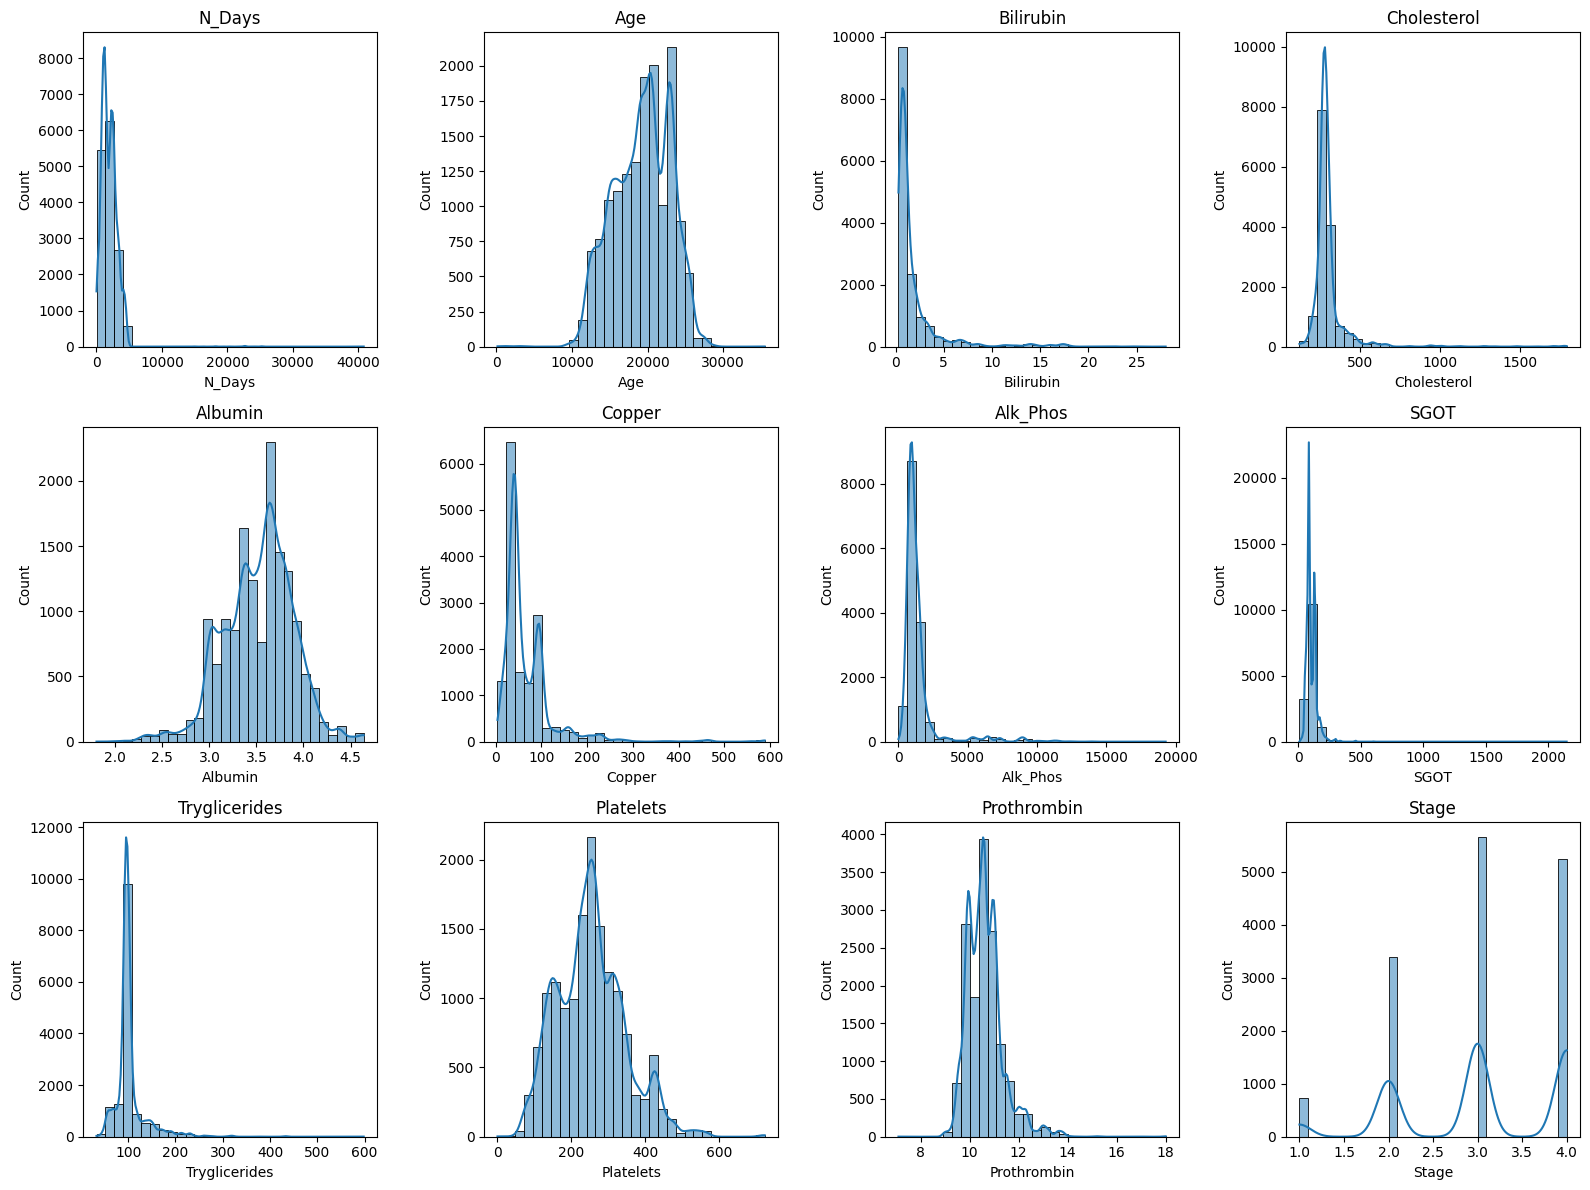

In [18]:
# Créer les histogrammes
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, col in enumerate(train_df1[num_cols]):
    ax = axes[i // 4, i % 4]
    sns.histplot(train_df1[col], bins=30, kde=True, ax=ax, palette='Set2')
    ax.set_title(col)

plt.tight_layout()
plt.show()

L’analyse des distributions des variables numériques met en évidence plusieurs observations importantes et corroborent l'analyse des statistiques descriptives réalisée plus haut :

1. **Présence de distributions asymétriques**

Plusieurs variables présentent une forte asymétrie positive, caractérisée par une concentration des observations autour de faibles valeurs et la présence de valeurs extrêmes élevées. C’est notamment le cas pour :
	•	N_Days, Bilirubin, Cholesterol, Copper, Alk_Phos, SGOT, et Tryglicerides.
Ces distributions indiquent une variabilité importante au sein de la population étudiée et suggèrent la nécessité de traitements spécifiques pour limiter l’influence des valeurs extrêmes (par exemple une standardisation robuste).

2. **Variables à distribution relativement symétrique**

Certaines variables présentent des distributions proches de la normale, ce qui facilite leur utilisation directe dans des modèles statistiques classiques. Il s’agit notamment de :
	•	Age, Albumin, Prothrombin, et Platelets.
Ces variables affichent une dispersion modérée autour de leur moyenne.

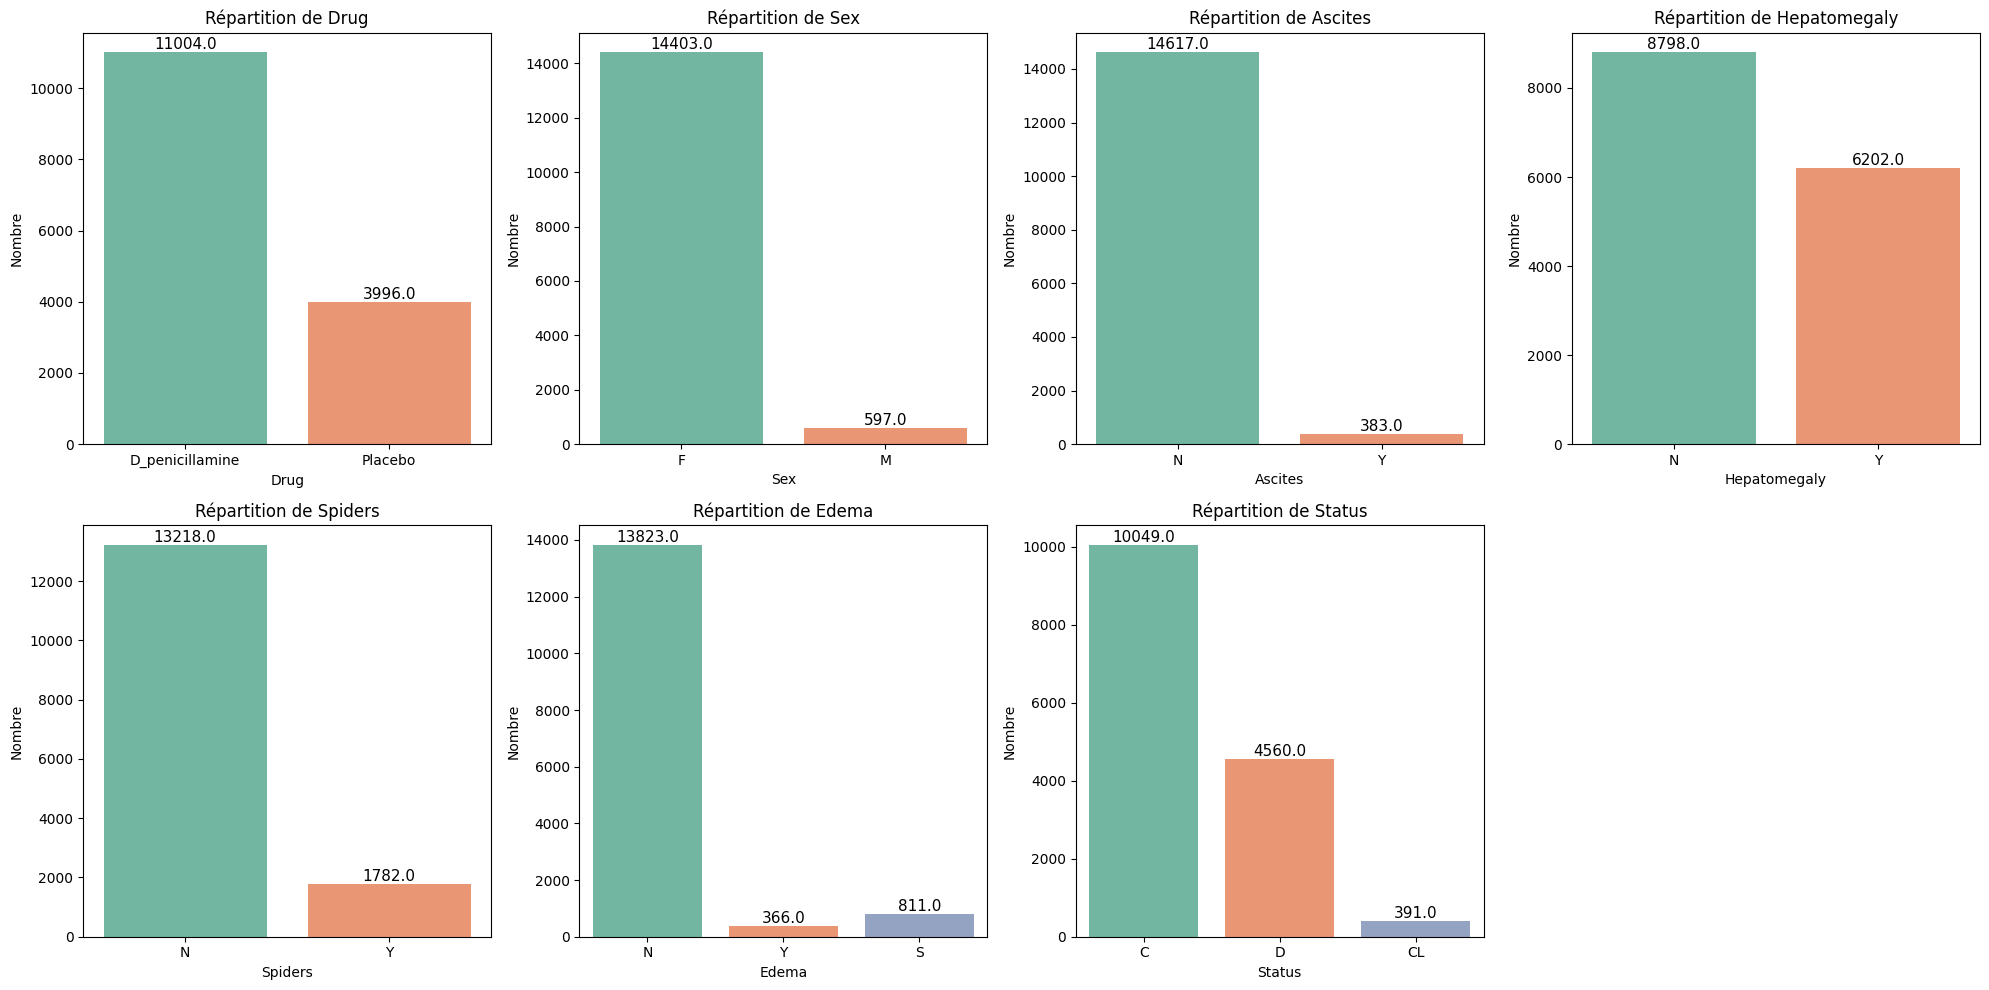

In [21]:
cat_cols = train_df1.select_dtypes('object').columns.tolist()
# Création des barplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, var in enumerate(cat_cols):
    ax = axes[i // 4, i % 4]
    plot = sns.countplot(data=train_df1, x=var, ax=ax, palette='Set2')
    ax.set_title(f'Répartition de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Nombre')
    
    # Ajout des data labels
    for p in plot.patches:
        height = p.get_height()
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=11, color='black', rotation=0)

# Suppression du dernier sous-graphe vide (car 7 plots sur 8 emplacements)
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()

#### **Analyse descriptive des variables catégorielles**

L’analyse des variables qualitatives met en évidence des déséquilibres notables au sein de la population étudiée :

1. **Répartition des traitements**

La majorité des patients ont reçu le traitement actif D-penicillamine (73,35 %), contre seulement 26,65 % pour le groupe placebo. Cette différence importante dans la répartition des traitements devra être prise en compte dans les analyses comparatives.

2. **Répartition par sexe**

La population est très largement féminine, avec 96,04 % de femmes contre seulement 3,96 % d’hommes. Ce déséquilibre pourrait influencer les résultats et limiter la généralisation des conclusions aux patients masculins.

3. **Présence d’ascite**

L’ascite est très peu fréquente dans l’échantillon, avec seulement 2,55 % des patients concernés. Cela limite son poids dans les analyses et nécessite prudence dans l’interprétation de son impact potentiel.

4. **Présence d’hépatomégalie**

L’hépatomégalie est observée chez 41,35 % des patients, ce qui en fait un paramètre clinique fréquent, susceptible de jouer un rôle significatif dans l’évolution de la maladie.

5. **Présence d’angiomes stellaires**

La majorité des patients (88,12 %) ne présentent pas d’angiomes stellaires, ce signe clinique étant relativement rare dans l’échantillon étudié.

6. **Présence d’œdème**

L’œdème est absent chez 92,15 % des patients. Lorsqu’il est présent, il est majoritairement observé sous forme légère ou subclinique (5,41 %), avec seulement 2,44 % de cas d’œdème avéré.

7. **Statut des patients**

Concernant l’évolution des patients :
* 66,99 % sont vivants,
* 30,40 % sont décédés,
* 2,61 % sont vivants mais transplantés.

Ces proportions mettent en évidence un taux de mortalité notable dans la cohorte.

### **Analyse bivariée - Table d'apprentissage**

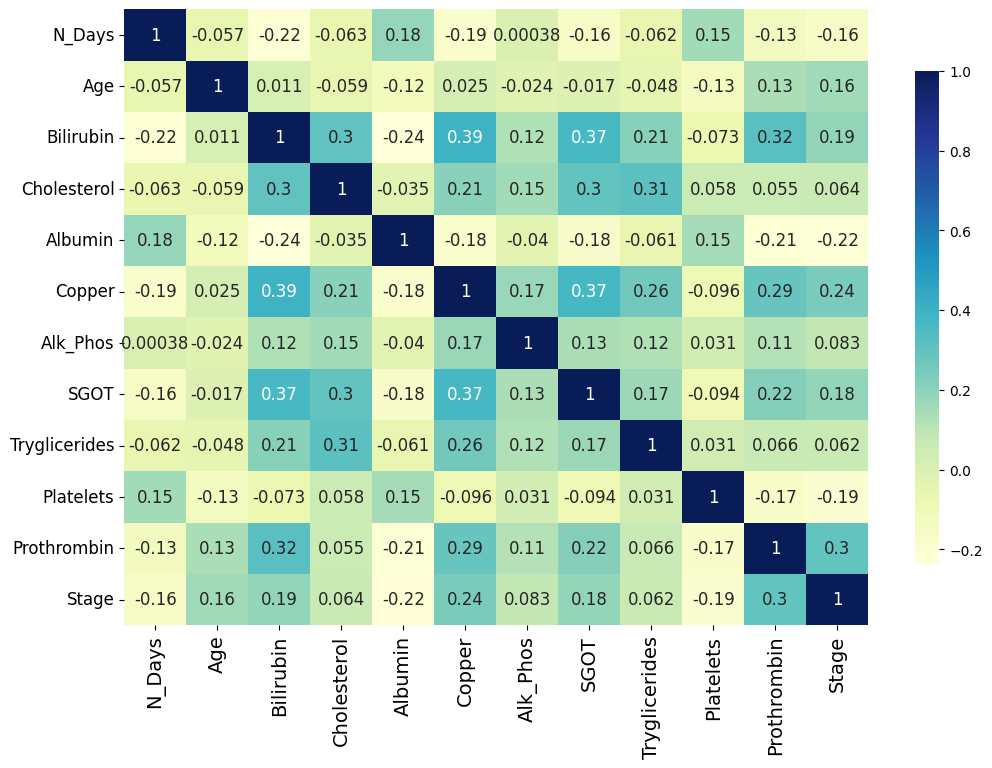

In [18]:
# Création d'un heatmap pour représenter le niveau des corrélations après le traitement des valeurs manquantes
plt.figure(figsize = (12, 8))
sns.heatmap(
    train_df1[num_cols].corr(), 
    annot=True, 
    cmap="YlGnBu", 
    annot_kws={"size": 12}, 
    cbar_kws={"shrink": 0.8}, 
)

# Ajuster les tailles des labels des axes
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)

plt.show();

#### **Analyse des corrélations entre variables continues après imputation des valeurs manquantes**

La matrice de corrélation ci-dessus permet d’évaluer les relations linéaires entre les principales variables continues de l’étude. Les résultats mettent en évidence plusieurs points clés :

1. Faibles corrélations globales

La majorité des coefficients de corrélation sont compris entre -0,3 et 0,4, indiquant des relations généralement faibles à modérées entre les variables. Cela suggère une faible redondance et un faible risque de multicolinéarité.

2. Corrélations positives notables
	•	Bilirubin montre des corrélations modérées avec Copper (0,39) et SGOT (0,37), suggérant que des niveaux élevés de bilirubine pourraient être associés à des perturbations de ces autres marqueurs hépatiques.
	•	Stage est modérément corrélé avec Prothrombin (0,30) et Copper (0,24), ce qui pourrait refléter un lien entre l’avancement de la maladie et la dégradation de certaines fonctions biologiques.

3. Corrélations négatives
	•	Albumin présente des corrélations négatives avec Stage (-0,22) et Bilirubin (-0,24), ce qui pourrait traduire une baisse de l’albumine chez les patients aux stades avancés de la maladie ou présentant des atteintes hépatiques sévères.

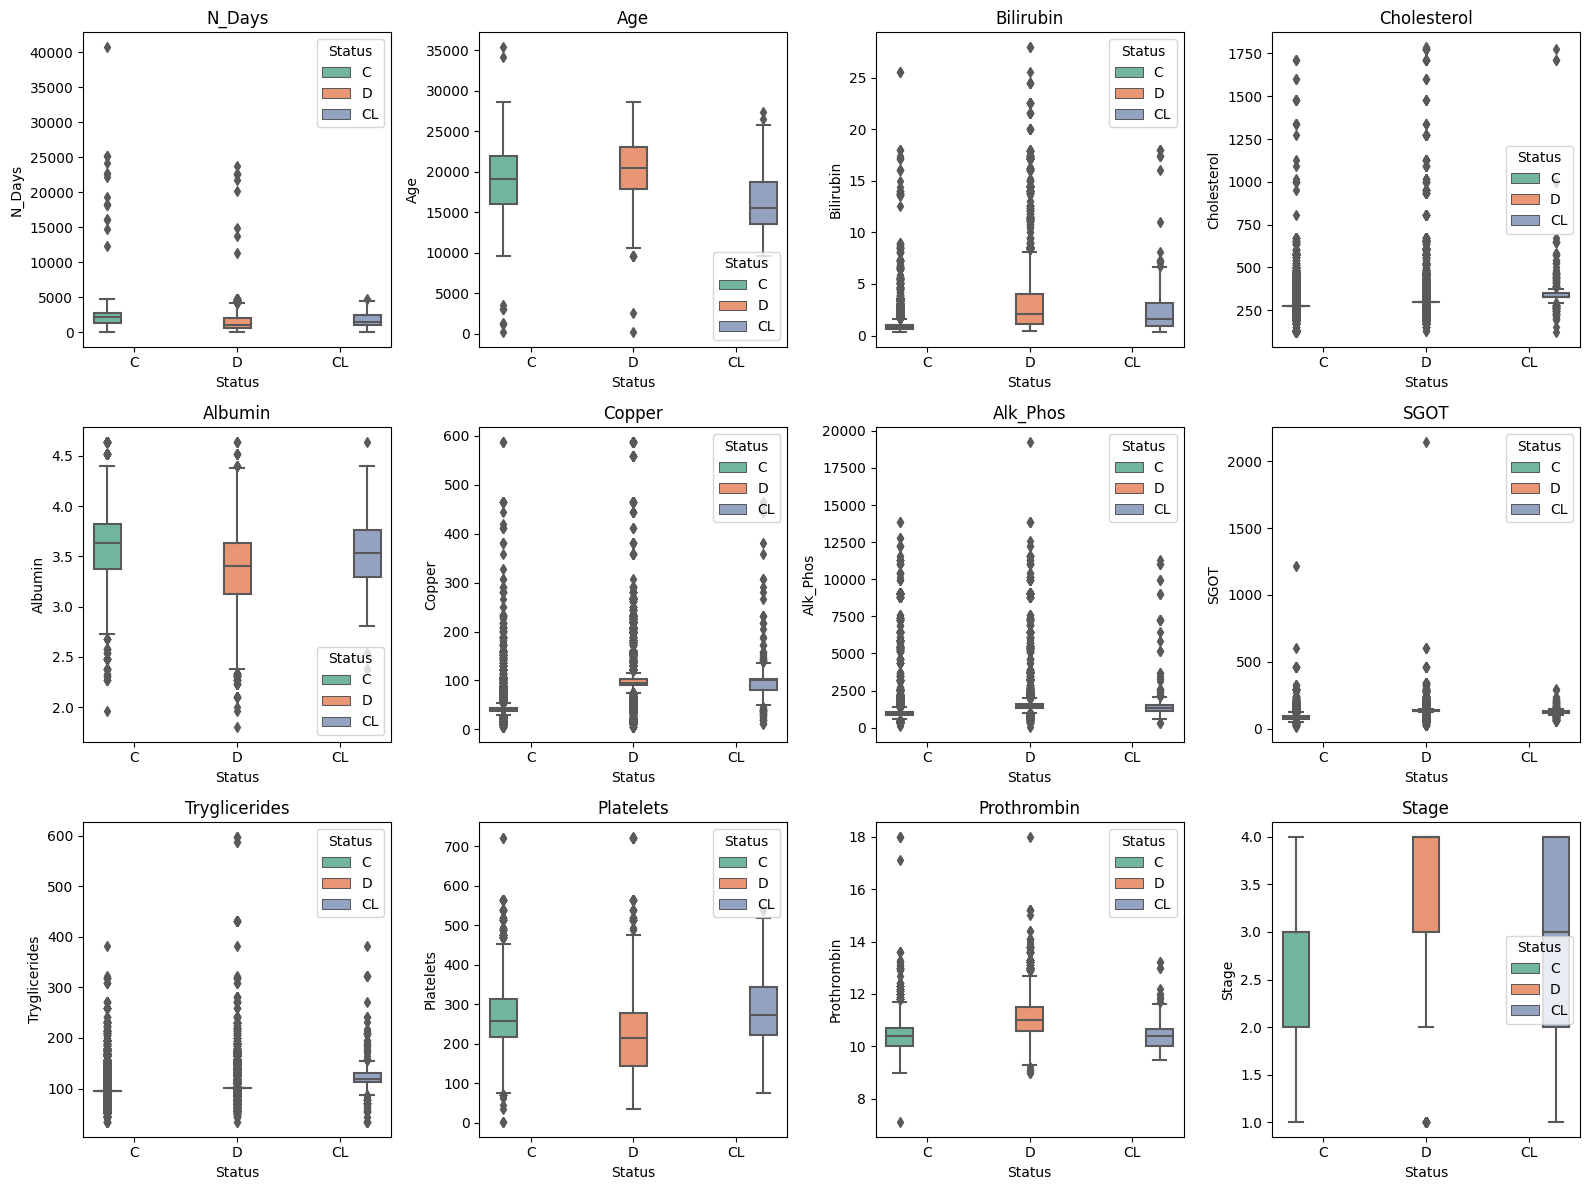

In [23]:
# Créer les boxplots
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, col in enumerate(train_df1[num_cols]):
    ax = axes[i // 4, i % 4]
    sns.boxplot(x=train_df1['Status'], y=train_df1[col], hue=train_df1['Status'], ax=ax, palette='Set2')
    ax.set_title(col)

plt.tight_layout()
plt.show()

#### **Analyse bivariée entre les variables continues et le statut des patients**

Les boxplots ci-dessus permettent d’évaluer la distribution des variables biologiques et cliniques en fonction du statut des patients (C : vivant, D : Décédé, CL : vivant mais transplanté). Plusieurs tendances significatives se dégagent de cette analyse :

1. **Différences biologiques selon le statut**

Les patients décédés (D) présentent des altérations marquées de plusieurs paramètres biologiques :
* Des niveaux plus élevés de Bilirubin, Copper, SGOT et Alk_Phos, indiquant une atteinte hépatique avancée.
* Des niveaux plus faibles d’Albumin, reflétant une dégradation de l’état nutritionnel ou une insuffisance hépatique.
* Une élévation de la Prothrombin, pouvant traduire des troubles de la coagulation associés à la progression de la maladie.

2. **Avancement de la maladie**

La variable Stage est significativement plus élevée chez les patients D et CL, confirmant que ces groupes présentent des stades plus avancés de la pathologie étudiée.

3. **Facteurs temporels**
* N_Days (durée de suivi) est plus longue chez les patients vivants (C) et plus courte chez les patients décédés (D), ce qui est cohérent avec des durées de survie plus réduites dans les cas les plus graves.
* L’âge des patients est légèrement plus élevé dans le groupe D, ce qui pourrait indiquer une vulnérabilité accrue avec l’âge.

4. **Présence importante de valeurs extrêmes**

Comme nous l'avons constaté dans les analyses précédentes, de nombreuses variables présentent des valeurs aberrantes (outliers), notamment SGOT, Alk_Phos, Cholesterol, et Copper. Ces valeurs extrêmes devront être traitées afin de limiter leur impact sur la modélisation.


Cette analyse met en évidence des différences biologiques et cliniques marquées entre les statuts des patients, ce qui souligne l’intérêt d’intégrer ces variables dans les modèles prédictifs.

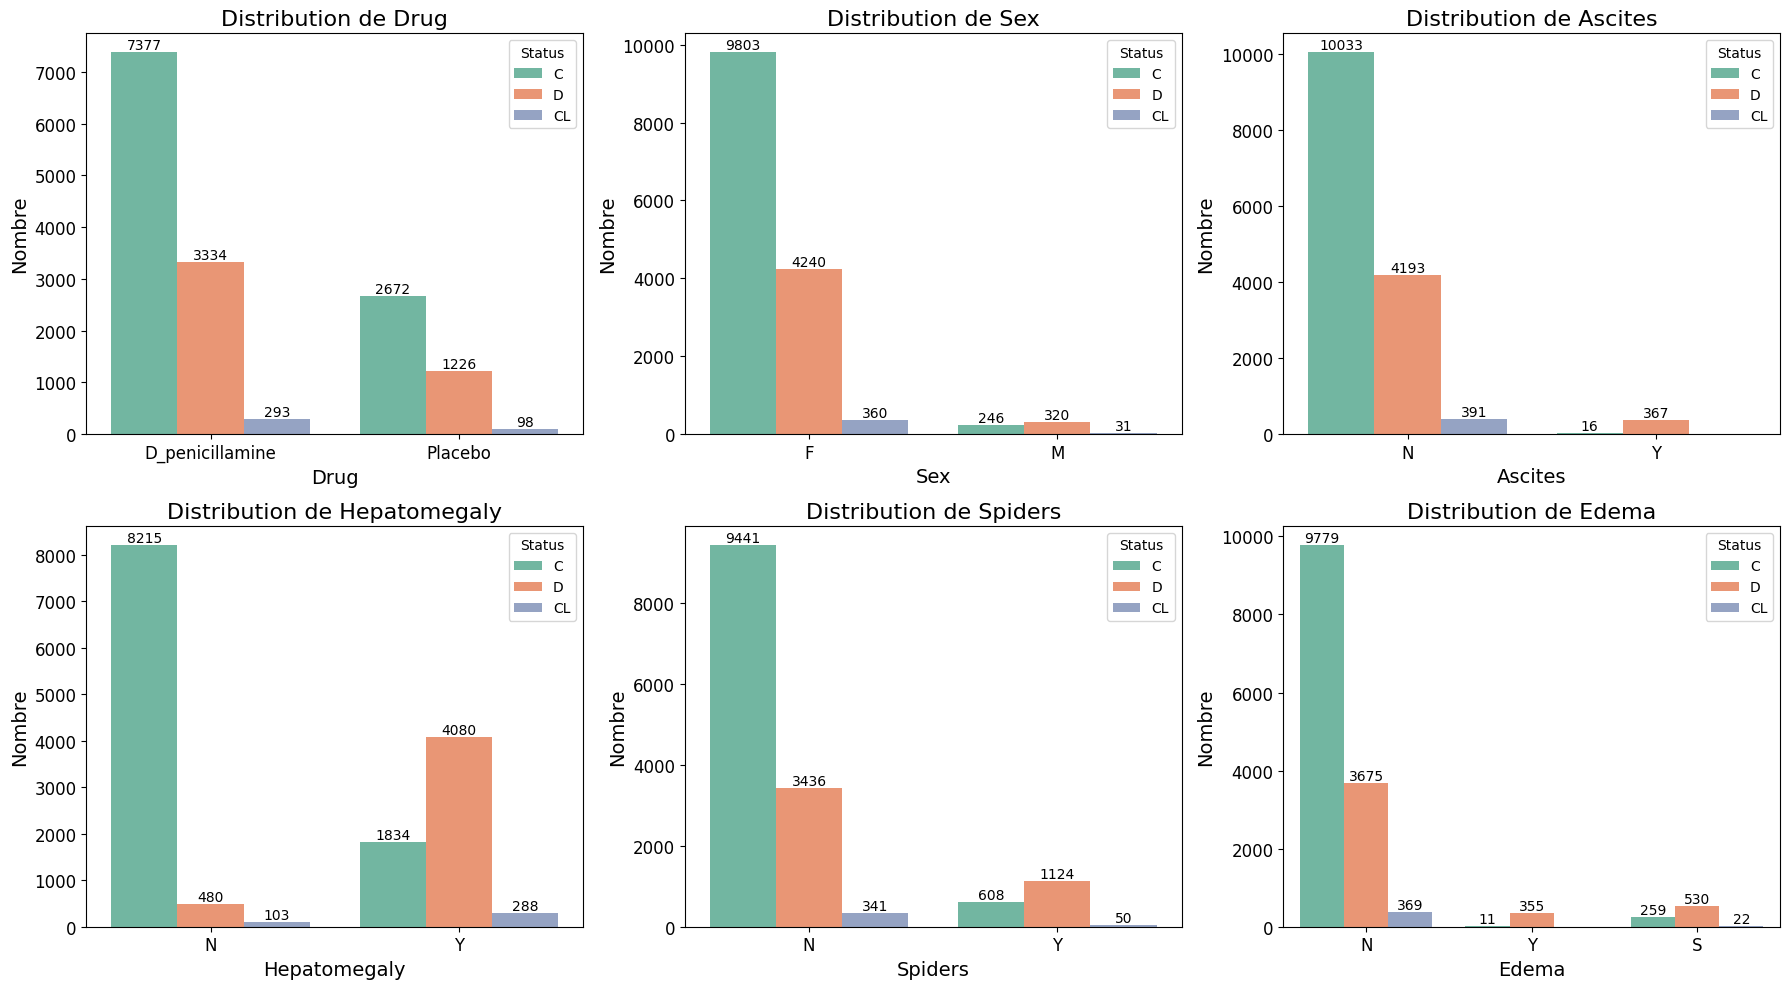

In [21]:
var_cat = train_df1.select_dtypes('object').columns.tolist()
var_cat.remove('Status')

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, var in enumerate(var_cat):
    ax = axes[i // 3, i % 3]
    plot = sns.countplot(data=train_df1, x=var, hue='Status', ax=ax, palette='Set2')
    ax.set_title(f'Distribution de {var}', fontsize=16)
    ax.set_xlabel(var, fontsize=14)
    ax.set_ylabel('Nombre', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Ajout des data labels
    for p in plot.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(f'{height}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

**Analyse des distributions croisées avec le statut**

Les graphiques montrent la répartition des différentes modalités des variables catégorielles selon le statut des patients (C : Vivant, D : Décédé, CL : Transplanté) :
* Drug : La majorité des patients ayant reçu le D-penicillamine sont vivants (C), tandis que ceux ayant reçu le Placebo présentent davantage de décès (D).
* Sex : La population est largement féminine (F), mais on remarque que la proportion de décès est plus élevée chez les hommes, bien qu'ils soient très peu représentés.
* Ascites : La grande majorité des patients sans ascite (N) sont vivants, tandis que la présence d’ascite (Y) est principalement associée aux patients décédés (D).
* Hepatomegaly : Les patients avec hépatomégalie (Y) présentent majoritairement un statut de décès (D), contrairement à ceux sans hépatomégalie (N) qui sont principalement vivants.
* Spiders : L’absence d’angiomes stellaires (N) est associée au statut vivant (C), tandis que leur présence (Y) est plus fréquente chez les patients décédés.
* Edema : Les patients sans œdème (N) sont majoritairement vivants, alors que la présence d’œdème (Y ou S) est plus fréquente parmi les patients décédés.


Ces croisements révèlent que certaines variables cliniques comme Ascites, Hepatomegaly, Spiders et Edema semblent fortement associées à un risque accru de décès.

### **Analyse Exploratoire des données - Table de test**

In [24]:
test_data.head(4)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,611.0,D-penicillamine,21828.0,F,N,Y,N,N,0.8,198.0,3.90,39.0,855.0,66.65,56.0,295.0,10.5,4.0
1,15001,2103.0,NaN,21915.0,F,NaN,NaN,NaN,N,0.6,NaN,3.81,NaN,NaN,NaN,NaN,269.0,10.5,3.0
2,15002,130.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.7,NaN,3.94,NaN,NaN,NaN,NaN,425.0,10.8,4.0
3,15003,1635.0,NaN,20089.0,F,NaN,NaN,NaN,N,0.6,NaN,3.50,NaN,NaN,NaN,NaN,248.0,10.3,2.0


In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   N_Days         9999 non-null   float64
 2   Drug           5660 non-null   object 
 3   Age            10000 non-null  float64
 4   Sex            10000 non-null  object 
 5   Ascites        5666 non-null   object 
 6   Hepatomegaly   5665 non-null   object 
 7   Spiders        5660 non-null   object 
 8   Edema          10000 non-null  object 
 9   Bilirubin      10000 non-null  float64
 10  Cholesterol    4438 non-null   float64
 11  Albumin        10000 non-null  float64
 12  Copper         5604 non-null   float64
 13  Alk_Phos       5660 non-null   float64
 14  SGOT           5656 non-null   float64
 15  Tryglicerides  4407 non-null   float64
 16  Platelets      9625 non-null   float64
 17  Prothrombin    9989 non-null   float64
 18  Stage  

**Observations**
* La table test contient 10000 observations et 19 variables. La variable 'Status' en est absente.
* Valeurs manquantes importantes : Plusieurs variables ont un fort taux de valeurs manquantes, notamment Drug, Ascites, Hepatomegaly, Spiders, et Cholesterol.
* Variables essentielles complètes : Age, Sex, Edema, Bilirubin, Albumin, et Stage sont entièrement renseignées, offrant une base fiable pour l’imputation des valeurs manquantes.

In [22]:
for var in test_data.select_dtypes('object').columns.tolist():
    print(var, test_data[var].unique())

Drug ['D-penicillamine' nan 'Placebo' 'Drug']
Sex ['F' 'M']
Ascites ['N' nan 'Y']
Hepatomegaly ['Y' nan 'N']
Spiders ['N' nan 'Y' 'C']
Edema ['N' 'S' 'Y']


In [23]:
test_data.loc[(test_data['Drug'] == 'D-penicillamine'), "Drug"] = "D_penicillamine"
test_data.loc[(test_data['Drug'] == 'Drug'), "Drug"] = train_df1['Drug'].mode()
test_data.loc[(test_data['Spiders'] == 'C'), "Spiders"] = train_df1['Spiders'].mode()

In [24]:
(test_data.isnull().sum() / test_data.shape[0]) * 100

id                0.00
N_Days            0.01
Drug             43.41
Age               0.00
Sex               0.00
Ascites          43.34
Hepatomegaly     43.35
Spiders          43.41
Edema             0.00
Bilirubin         0.00
Cholesterol      55.62
Albumin           0.00
Copper           43.96
Alk_Phos         43.40
SGOT             43.44
Tryglicerides    55.93
Platelets         3.75
Prothrombin       0.11
Stage             0.00
dtype: float64

In [25]:
test_na_cat = test_data.select_dtypes(['object']).isnull().sum()[test_data.select_dtypes(['object']).isnull().sum() > 0].index.to_list()

for var in test_na_cat:
    test_data[var] = test_data[var].fillna(train_df1[var].mode().iloc[0])

Nous avons imputé les valeurs manquantes des variables catégorielles de la table de test en les remplaçant par le mode de la variable correspondante, calculé à partir de la table d’apprentissage. Cette méthode permet de préserver la cohérence des données en attribuant la modalité la plus fréquente, tout en réduisant l’impact des valeurs manquantes sur l’analyse.

In [26]:
test_na_num = test_data.select_dtypes(['int', 'float']).isnull().sum()[test_data.select_dtypes(['int', 'float']).isnull().sum() > 0].index.to_list()

for var in test_na_num:
    test_data[var] = test_data[var].fillna(train_df1[var].median())

Nous avons imputé les valeurs manquantes des variables numériques de la table de test en les remplaçant par la médiane globale correspondante, calculée à partir de la table d’apprentissage. Cette approche permet de préserver la distribution des données et de limiter l’impact des valeurs extrêmes, tout en assurant la cohérence entre les ensembles d’apprentissage et de test.

In [24]:
test_data.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

## **Modélisation**

In [57]:
# Enlever la variable 'id'
test_df1 = test_data.drop('id', axis = 1)

# Variable indépendantes et variable cible
X_train = train_df1.drop('Status', axis = 1)
y_train = train_df1['Status']

X_test = test_df1.copy()

In [58]:
var_cat = X_train.select_dtypes('object').columns.to_list()
var_num = X_train.select_dtypes(["int64", "float64"]).columns.tolist()
var_num.remove('Stage')

#### **Pré-traitement des données**

In [59]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Préparation des données pour la régression - Train Dataset
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoded_train_data = encoder.fit_transform(X_train[var_cat])

# Créer un DataFrame pour les colonnes encodées
encoded_columns = encoder.get_feature_names_out(var_cat)
encoded_train_df = pd.DataFrame(encoded_train_data, columns=encoded_columns, index=X_train.index)

# Préparation des données pour la régression - Test Dataset
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoded_test_data = encoder.fit_transform(X_test[var_cat])

# Créer un DataFrame pour les colonnes encodées
encoded_columns = encoder.get_feature_names_out(var_cat)
encoded_test_df = pd.DataFrame(encoded_test_data, columns=encoded_columns, index=X_test.index)

In [60]:
X_train_num = X_train[var_num]
X_test_num = X_test[var_num]

# Standardisation des variables numériques
scaler = RobustScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=var_num)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=var_num)

# Concaténation des variables catégorielles et numériques
X_train_scaled = pd.concat([encoded_train_df, X_train_num_scaled, X_train[['Stage']]], axis = 1)
X_test_scaled = pd.concat([encoded_test_df, X_test_num_scaled, X_test[['Stage']]], axis = 1)

# Split train into Train (70%) and Evaluation (30%) sets
X_train, X_eval, y_train_mod, y_eval = train_test_split(X_train_scaled, y_train, test_size=0.3, stratify=y_train, random_state=42)

#### **Explications**
Avant l’entraînement du modèle, un traitement approprié des variables a été réalisé afin d’assurer une meilleure performance et stabilité de la régression logistique multinomiale. D’une part, les variables catégorielles ont été transformées à l’aide du One-Hot Encoding, une méthode qui consiste à convertir chaque modalité d’une variable en une colonne binaire (0 ou 1). Cette approche permet d’intégrer correctement les variables qualitatives dans le modèle sans introduire d’ordre artificiel entre les catégories et tout en préservant l’information associée à chacune d’elles.

D’autre part, les variables numériques ont été standardisées à l’aide du Robust Scaler, un outil particulièrement adapté en présence de valeurs extrêmes. Contrairement aux méthodes classiques de normalisation (comme la standardisation basée sur la moyenne et l’écart-type), le Robust Scaler repose sur la médiane et l’écart interquartile (IQR) pour centrer et réduire les variables. Cela permet de limiter l’influence des valeurs aberrantes et de garantir que l’échelle des variables reste cohérente, ce qui est essentiel pour les modèles sensibles à la magnitude des données, comme la régression logistique.

Finalement, nous avons divisé notre table d'apprentissage en table d'apprentissage et table d'évaluation pour pouvoir évaluer et contrôler notre modèle.

Ce prétraitement combiné assure ainsi que l’ensemble des variables, qu’elles soient catégorielles ou numériques, contribuent efficacement et de manière équilibrée à l’apprentissage du modèle.

### **Multinomial Logistic Regression**

In [62]:
# Define Model and Hyperparameter Grid**
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    "solver": ["lbfgs", "newton-cg", "saga"]
}

# Cross-Validation Strategy
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform GridSearchCV with neg_log_loss
grid_search = GridSearchCV(
    LogisticRegression(max_iter=4000),
    param_grid,
    cv=cv_strategy,
    scoring="neg_log_loss",
    verbose=3,
    n_jobs=-1
)

# Train Best Model
grid_search.fit(X_train, y_train_mod)

# Tirer le meilleur modèle et les paramètres
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Mean Log Loss (CV): {-grid_search.best_score_}")  # Convert back to positive log loss

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best Parameters: {'C': 100, 'solver': 'newton-cg'}
Best Mean Log Loss (CV): 0.3278253338663549


Afin d’optimiser la performance de la régression logistique multinomiale, une recherche de grille (GridSearchCV) a été réalisée avec validation croisée à 10 folds sur 18 combinaisons de paramètres, soit un total de 180 ajustements. Les meilleurs hyperparamètres identifiés sont C = 100 (faible régularisation) et solver = ‘newton-cg’, un algorithme adapté aux problèmes multiclasse. La meilleure performance obtenue lors de la validation croisée est un log loss moyen de 0,328, indiquant une bonne capacité du modèle à prédire correctement les probabilités des classes tout en pénalisant les mauvaises estimations.

La faible régularisation observée (C élevé ==> lambda faible) se justifie par la structure des données : l’analyse exploratoire a révélé un niveau de corrélation faible à modéré entre les variables, limitant ainsi le risque de multicolinéarité, et l’ensemble des variables a été jugé informatif, ce qui encourage à conserver toute leur contribution dans le modèle sans appliquer de pénalisation excessive.

In [63]:
# Probability Calibration
calibrated_model = CalibratedClassifierCV(best_model, method="sigmoid", cv="prefit")
calibrated_model.fit(X_train, y_train_mod)

# Evaluate on Validation Set
y_eval_proba_raw = best_model.predict_proba(X_eval)
y_eval_proba_calibrated = calibrated_model.predict_proba(X_eval)

# Compute Log Loss Before and After Calibration
raw_log_loss = log_loss(y_eval, y_eval_proba_raw)
calibrated_log_loss = log_loss(y_eval, y_eval_proba_calibrated)

print(f"Raw Log Loss: {raw_log_loss}")
print(f"Calibrated Log Loss: {calibrated_log_loss}")

Raw Log Loss: 0.32861269646812374
Calibrated Log Loss: 0.3475941233551292


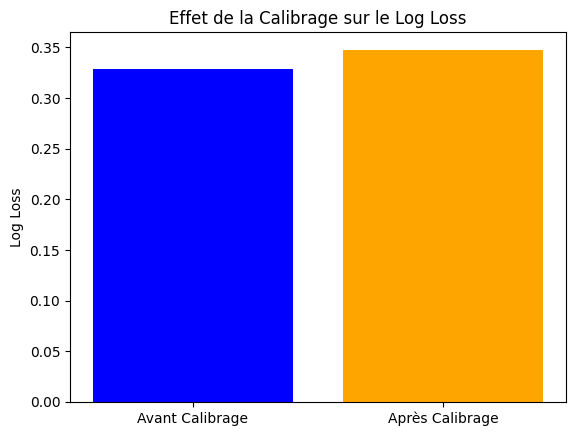

In [88]:
# Plot Log Loss evolution
plt.bar(["Avant Calibrage", "Après Calibrage"], [raw_log_loss, calibrated_log_loss], color=["blue", "orange"])
plt.ylabel("Log Loss")
plt.title("Effet de la Calibrage sur le Log Loss")
plt.show()

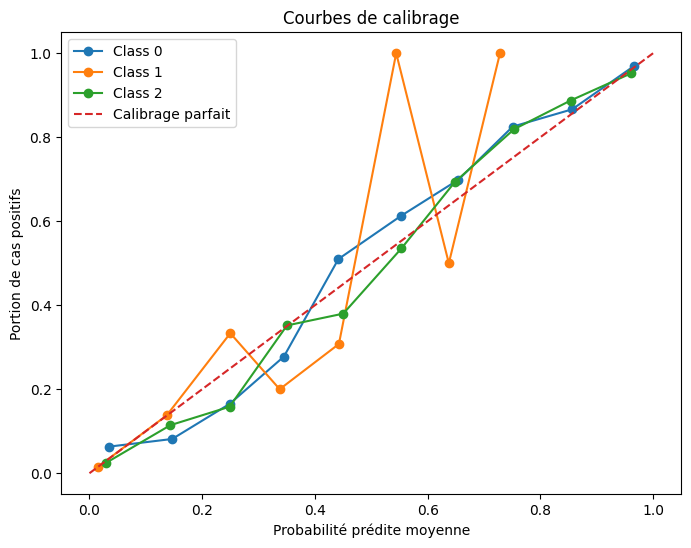

In [90]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))
for i in range(3):  # For each class
    prob_true, prob_pred = calibration_curve(y_eval == i, y_eval_proba_raw[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"Class {i}")

plt.plot([0, 1], [0, 1], linestyle="--", label="Calibrage parfait")
plt.xlabel("Probabilité prédite moyenne")
plt.ylabel("Portion de cas positifs")
plt.title("Courbes de calibrage")
plt.legend()
plt.show()

L’évaluation du modèle a montré un log loss de 0,3286 avec les meilleurs hyperparamètres obtenus lors de la recherche de grille, ce qui indique une bonne capacité du modèle à estimer correctement les probabilités des classes. Après calibration, le log loss est légèrement remonté à 0,3475, traduisant une dégradation modeste des performances.

Cette hausse suggère que le modèle initial était déjà bien calibré, ce que confirme également le graphique des courbes de calibration. Ce dernier montre que le modèle fournit des probabilités globalement cohérentes pour certaines classes, avec des courbes proches de la diagonale idéale. Toutefois, une des classes (ici Class 1) présente une calibration plus instable, avec des écarts marqués, ce qui traduit des difficultés du modèle à estimer correctement les probabilités pour cette classe.

Dans ce contexte, la calibration n’apporte pas de bénéfice significatif et confirme la robustesse du modèle optimisé dans son état initial. Par conséquent, nous retiendrons le meilleur modèle avant calibration pour effectuer les prédictions finales, afin de conserver ses performances optimales observées lors de la validation croisée.

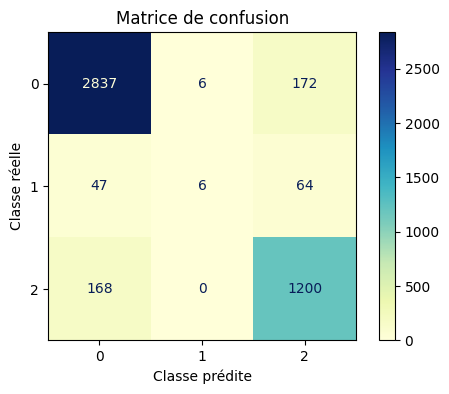

In [84]:
# Predict on the evaluation set
y_eval_preds = best_model.predict(X_eval)
cm = confusion_matrix(y_eval, y_eval_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(cmap="YlGnBu", ax=ax, values_format='d')  # 'd' means integer format
plt.title("Matrice de confusion")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()

**Analyse de la matrice de confusion pour l'ensemble de validation**

La matrice de confusion permet d’évaluer la capacité du modèle à distinguer les trois classes cibles. Les résultats montrent que la Classe 0 (Status_C) est globalement bien prédite avec 2837 bonnes classifications, malgré 172 confusions avec la Classe 2 (Status_CL). La Classe 2 est également bien identifiée avec 1200 bonnes prédictions, mais présente des confusions notables avec la Classe 0 (168 cas).

En revanche, la Classe 1 (Status_D) pose davantage de difficultés au modèle, avec seulement 6 cas correctement prédits, tandis que la majorité des observations de cette classe sont réparties entre les Classes 0 et 2. Cette mauvaise performance sur la Classe 1 corrobore les irrégularités observées dans la courbe de calibration, suggérant que le modèle peine à capter efficacement les spécificités de cette classe, possiblement à cause du déséquilibre par rapport aux autres classes ou d’une proximité avec les autres profils.

In [63]:
# Generate Final Predictions on Kaggle Test Set
y_test_proba_final = best_model.predict_proba(X_test_scaled)

# Store Predictions for External Use
probability_df = pd.DataFrame(y_test_proba_final, columns=label_encoder.classes_)

probability_df.insert(0, "id", test_data['id'])
probability_df.rename(columns={'C': 'Status_C',
                              'CL': 'Status_CL',
                              'D': 'Status_D'}, inplace = True)

probability_df.to_csv("submission_mlr.csv", index=False)

print(probability_df.head())

# Save Submission File**
print("Fichier sauvegardé sous 'submission_mlr.csv'")

      id  Status_C  Status_CL  Status_D
0  15000  0.774403   0.013111  0.212486
1  15001  0.966874   0.003242  0.029884
2  15002  0.950494   0.003502  0.046004
3  15003  0.971919   0.004726  0.023355
4  15004  0.990758   0.006642  0.002600
Fichier sauvegardé sous 'submission_mlr.csv'


Après avoir identifié le meilleur modèle et constaté qu’il était déjà globalement calibré, nous avons retenu ce dernier pour réaliser les prédictions finales. Il est important de noter que le modèle a déjà été évalué sur un jeu de données indépendant (evaluation set), ce qui a permis de valider sa capacité à généraliser en dehors des données d’apprentissage. 

Cette bonne performance sur des données non vues confirme la stabilité du modèle et justifie l’utilisation directe du modèle optimisé pour générer les prédictions finales et interpréter les résultats dans le cadre de l’étude.

#### **Première conlusion**

Malgré les performances du modèle, d'acceptables à bonnes, sur nos propres jeux de données, nous constatons une augmentation notable du log loss à 0,64 lors de l’évaluation sur le dataset Kaggle, ce qui nous conduit à poursuivre l’exploration d’autres modèles afin d’améliorer la qualité des prédictions.

### **XGBoost**

Afin d’améliorer la performance des prédictions, nous avons décidé de tester un modèle XGBoost. Il s’agit d’un algorithme de gradient boosting particulièrement performant pour les tâches de classification, notamment grâce à sa capacité à gérer les relations complexes entre les variables et à limiter le surapprentissage.

De plus, XGBoost est robuste face aux valeurs aberrantes et aux déséquilibres dans les données, ce qui en fait un candidat pertinent dans le contexte de notre étude. L’objectif est ainsi de comparer ses performances à celles obtenues avec la régression logistique et d’évaluer sa capacité à réduire le log loss sur le dataset Kaggle.

In [84]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer

# Nouvelle importation des données
train_data = pd.read_csv("/kaggle/input/classification-multi-classes/train.csv")
test_data = pd.read_csv("/kaggle/input/classification-multi-classes/test.csv")

train_df = train_data.drop('id', axis = 1)
test_df = test_data.drop('id', axis = 1)

# Encodage des variables catégoriques explicatives
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
num_cols = train_df.select_dtypes(include=['number']).columns.tolist()
cat_cols.remove("Status")

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = one_hot_encoder.fit_transform(train_df[cat_cols])
X_test_cat = one_hot_encoder.transform(test_df[cat_cols])

# Conversion en DataFrame et alignement avec X_train/X_test
X_train_cat = pd.DataFrame(X_train_cat, index=train_df.index)
X_test_cat = pd.DataFrame(X_test_cat, index=test_df.index)

# Sélection des features numériques
X_train_num = train_df[num_cols]
X_test_num = test_df[num_cols]

# Fusion des features numériques et catégoriques
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

# Encodage de la variable cible 'Status'
label_encoder_status = LabelEncoder()
y_train = label_encoder_status.fit_transform(train_df['Status'])

In [85]:
# On s'assure que X_test contient les mêmes colonnes que X_train
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Définition de la fonction de score basé sur l'opposé de la log-vraisemblance
def log_loss_opposite(y_true, y_pred_prob):
    return -log_loss(y_true, y_pred_prob)

scorer = make_scorer(log_loss_opposite, greater_is_better=True, needs_proba=True)

# Recherche de meilleurs hyperparamètres
param_grid = {
    'n_estimators': [800, 1000, 1200],
    'max_depth': [7, 8, 10],
    'learning_rate': [0.01, 0.02, 0.03],
    'subsample': [0.2, 0.3, 0.5, 0.7],
    'colsample_bytree': [0.2, 0.3, 0.5]
}

# Initialisation du modèle
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Recherche sur grille pour optimiser le modèle
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring=scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f" Meilleurs hyperparamètres : {best_params}")
print(f" Meilleur score (opposé de la log-vraisemblance) obtenu : {-grid_search.best_score_}")

 Meilleurs hyperparamètres : {'colsample_bytree': 0.2, 'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.7}
 Meilleur score (opposé de la log-vraisemblance) obtenu : 0.35533350673699987


In [87]:
# Entraînement du modèle avec les meilleurs hyperparamètres
best_xgb_model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
best_xgb_model.fit(X_train, y_train)

print("\n Modèle XGBoost entraîné avec succès.")

# Prédictions sur le set test_df
predictions = best_xgb_model.predict_proba(X_test)

# Création du fichier de soumission
submission = pd.DataFrame(predictions, columns=['Status_C', 'Status_CL', 'Status_D'])
submission['id'] = test_data['id']  # Ajouter l'ID des individus
submission = submission[['id', 'Status_C', 'Status_CL', 'Status_D']]

# Sauvegarde du fichier pour soumission
submission.to_csv('submission_test_xgb.csv', index=False)
print("\n Fichier 'submission_test_xgb.csv' créé avec succès.")


 Modèle XGBoost entraîné avec succès.

 Fichier 'submission_test_xgb.csv' créé avec succès.


**Résultats**

L’application du modèle XGBoost a permis d’obtenir un log loss de 0,3553 sur notre jeu de données d'entraînement, ce qui est légèrement supérieur à la performance obtenue avec la régression logistique. Toutefois, le modèle montre une meilleure capacité de généralisation sur le dataset Kaggle, avec un log loss réduit à 0,3479, inférieur à celui observé avec la régression logistique sur ce même jeu. 

Ces résultats indiquent que XGBoost parvient à mieux s’adapter aux spécificités du dataset externe, ce qui confirme l’intérêt de recourir à des modèles plus complexes pour améliorer la qualité des prédictions et la robustesse face à des données nouvelles.

Voyons si nous pouvons faire mieux avec un réseau de neurones!

### **Réseau de neurones**

In [ ]:
# Importation des librairies nécessaires
import torch
import torch.nn as nn
import torch.optim as optim

In [51]:
# Conversion en ndarray
X_train_array = X_train_scaled.to_numpy()
X_test_array = X_test_scaled.to_numpy()

# Conversion en tenseurs PyTorch
X_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)

#  Définition du modèle MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = MLP(input_dim=X_tensor.shape[1], output_dim=len(label_enc.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [52]:
# Entraînement du modèle
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}")

Epoch 1/50 - Loss: 1.1149
Epoch 2/50 - Loss: 0.8528
Epoch 3/50 - Loss: 0.7500
Epoch 4/50 - Loss: 0.6130
Epoch 5/50 - Loss: 0.5623
Epoch 6/50 - Loss: 0.5031
Epoch 7/50 - Loss: 0.4672
Epoch 8/50 - Loss: 0.4430
Epoch 9/50 - Loss: 0.4120
Epoch 10/50 - Loss: 0.3936
Epoch 11/50 - Loss: 0.3767
Epoch 12/50 - Loss: 0.3591
Epoch 13/50 - Loss: 0.3491
Epoch 14/50 - Loss: 0.3454
Epoch 15/50 - Loss: 0.3422
Epoch 16/50 - Loss: 0.3387
Epoch 17/50 - Loss: 0.3355
Epoch 18/50 - Loss: 0.3318
Epoch 19/50 - Loss: 0.3265
Epoch 20/50 - Loss: 0.3199
Epoch 21/50 - Loss: 0.3138
Epoch 22/50 - Loss: 0.3084
Epoch 23/50 - Loss: 0.3034
Epoch 24/50 - Loss: 0.2997
Epoch 25/50 - Loss: 0.2978
Epoch 26/50 - Loss: 0.2964
Epoch 27/50 - Loss: 0.2944
Epoch 28/50 - Loss: 0.2921
Epoch 29/50 - Loss: 0.2900
Epoch 30/50 - Loss: 0.2876
Epoch 31/50 - Loss: 0.2853
Epoch 32/50 - Loss: 0.2836
Epoch 33/50 - Loss: 0.2822
Epoch 34/50 - Loss: 0.2806
Epoch 35/50 - Loss: 0.2792
Epoch 36/50 - Loss: 0.2779
Epoch 37/50 - Loss: 0.2763
Epoch 38/5

In [53]:
# 6. Prédiction sur le jeu de test
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predictions = torch.softmax(test_outputs, dim=1).numpy()

In [56]:
# Création du fichier de soumission
probability_df = pd.DataFrame(predictions, columns=label_encoder.classes_)

probability_df.insert(0, "id", test_data['id'])
probability_df.rename(columns={'C': 'Status_C',
                              'CL': 'Status_CL',
                              'D': 'Status_D'}, inplace = True)

probability_df.to_csv("submission_RN.csv", index=False)

print(probability_df.head())

# Save Submission File**
print("\nFichier sauvegardé sous 'submission_RN.csv'")

      id  Status_C  Status_CL  Status_D
0  15000  0.902622   0.000310  0.097068
1  15001  0.994314   0.000426  0.005260
2  15002  0.995604   0.000183  0.004213
3  15003  0.994675   0.000680  0.004645
4  15004  0.992182   0.001647  0.006171

Fichier sauvegardé sous 'submission_RN.csv'


Dans le cadre de notre démarche d’optimisation, nous avons testé l’utilisation d’un réseau de neurones multi-couches (MLP) afin d’évaluer s’il pouvait apporter une amélioration de performance sur notre problème de classification. Après avoir converti nos données normalisées en tableaux NumPy, puis en tenseurs PyTorch, nous avons défini un MLP simple composé de deux couches cachées avec des activations ReLU. 

Cependant, malgré cette tentative, le score public a fortement dégradé jusqu’à atteindre 0,84, ce qui traduit une mauvaise performance du modèle sur le jeu de test Kaggle. Ces résultats confirment que ce type de modèle n’est pas idéal pour ce problème, probablement en raison de la taille du dataset, du déséquilibre des classes ou du fait que le problème ne nécessite pas la complexité d’un réseau de neurones. Nous avons ainsi choisi de ne pas retenir cette approche pour nos prédictions finales.

---

## **Conclusion générale**

Ce travail avait pour objectif de développer un modèle de classification capable de prédire le statut clinique de patients atteints d’une maladie hépatique, à partir de données cliniques et biologiques. Après une phase d’analyse exploratoire approfondie, nous avons traité les valeurs manquantes et les valeurs aberrantes afin d’assurer la qualité des données utilisées pour la modélisation.

Nous avons d’abord construit un modèle de régression logistique multinomiale, qui s’est révélé performant avec un log loss de 0,3286 lors de la validation croisée. L’analyse de calibration a montré que ce modèle était déjà bien calibré, sans nécessiter d’ajustements supplémentaires. Cependant, lors de l’évaluation sur le dataset externe de Kaggle, le score s’est dégradé, révélant des limites dans la généralisation.

Dans un souci d’amélioration, nous avons expérimenté d’autres approches, notamment un modèle XGBoost, qui a permis de légèrement améliorer le score public sur Kaggle, atteignant 0,3479, confirmant une meilleure robustesse face aux spécificités du dataset externe. Enfin, l’utilisation d’un réseau de neurones (MLP) n’a pas été concluante, le score public ayant fortement chuté à 0,84, ce qui confirme que ce type de modèle n’est pas adapté au contexte et aux caractéristiques de nos données.

En conclusion, bien que plusieurs approches aient été testées, la régression logistique multinomiale et XGBoost apparaissent comme les solutions les plus appropriées pour ce problème multiclasses, avec des performances stables et interprétables. Des pistes d’amélioration restent possibles, notamment en travaillant sur l’équilibre des classes, l’ingénierie des variables ou encore des techniques avancées de calibration pour affiner les probabilités prédites.